In [1]:
from google.colab import output

!pip install -q clearml

output.clear()
print("Installation is completed successfully.")

Installation is completed successfully.


In [2]:
# # Log in to your clearml account
# import clearml
# clearml.browser_login()

In [3]:
from clearml import Task

Task.set_credentials(
     api_host="https://api.clear.ml", 
     web_host="https://app.clear.ml", 
     files_host="https://files.clear.ml", 
     key='', # access API
     secret='' # secret API
)

In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score
from tqdm import tqdm

In [5]:
# Loading Data

# MNIST dataset
def make_loader(batch_size, train=True, shuffle=True):
    full_dataset = datasets.MNIST(root='./data/MNIST', train=train, 
                                    download=True,  transform=transforms.ToTensor())
    
    loader = DataLoader(dataset=full_dataset,
                        batch_size=batch_size, 
                        shuffle=shuffle,
                        pin_memory=True, num_workers=2)

    return loader

In [6]:
class ConvNet(nn.Module):
    def __init__(self, classes=10):
        super(ConvNet, self).__init__()
        # self.fc1 = nn.Linear(784, 512)
        # self.fc2 = nn.Linear(512, 256)
        # self.fc3 = nn.Linear(256, 128)
        # self.fc4 = nn.Linear(128, 64)
        # self.fc5 = nn.Linear(64, 32)
        # self.fc6 = nn.Linear(32, 10)

        self.fc1 = nn.Linear(784, 256)
        # self.fc2 = nn.Linear(512, 256)
        self.fc2 = nn.Linear(256, 64)
        # self.fc4 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        # self.fc6 = nn.Linear(32, 10)

    def forward(self, x):
        x = x.float()
        h1 = F.relu(self.fc1(x.view(-1, 784)))
        h2 = F.relu(self.fc2(h1))
        # h3 = F.relu(self.fc3(h2))
        # h4 = F.relu(self.fc4(h3))
        # h5 = F.relu(self.fc5(h4))
        h3 = self.fc3(h2)
        
        return F.log_softmax(h3, dim=1)

print("init model done")

init model done


In [7]:
def train(model, loader, criterion, optimizer, device, config):
    cumu_loss = 0
    tqdm_loader = tqdm(loader)

    for images, labels in tqdm_loader:
        images, labels = images.to(device), labels.to(device)
        logit = model(images)
        loss = criterion(logit, labels)
        cumu_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    return loss

In [8]:
def valid(model, test_loader, first_batch_only=False):
    model.eval()
    acc_list = []
    labels_list = []
    pred_list = []
    
    with torch.no_grad():
        tqdm_loader = tqdm(test_loader)
        for images, labels in tqdm_loader:
            logit = model(images)
            pred = torch.argmax(logit, dim=1)
            batch_acc = accuracy_score(labels, pred)
            acc_list.append(batch_acc)
            labels_list.append(labels)
            pred_list.append(pred)

            if first_batch_only:
                break

    return sum(acc_list) / len(acc_list), labels_list, pred_list

In [9]:
from clearml import Task
import torch.optim as optim

def run(config=None):
    task = Task.init(project_name='MNIST-project', task_name='experiment')
    task.connect(config, 'config')

    device = "cuda" if torch.cuda.is_available() else "cpu"

    train_loader = make_loader(batch_size=config['batch_size'], train=True)
    test_loader = make_loader(batch_size=config['batch_size'], train=False)

    # model = ConvNet(config['kernels'], config['classes']).to(device)
    model = ConvNet().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'])

    for epoch in range(1, config['epochs']):
        loss = train(model, train_loader, criterion, optimizer, device, config)
        # acc = valid(model, test_loader)
        acc, _, _ = valid(model, test_loader)

        print(f"[Train] Epoch {epoch:02} | Loss: {loss:.2f}")
        print(f"[Vaild] Epoch {epoch:02} | Acc: {acc:.3f}")

        task.get_logger().report_scalar(title="Loss", series="train", value=loss, iteration=epoch)
        task.get_logger().report_scalar(title="Accuracy", series="val", value=acc, iteration=epoch)        
    
        # if epoch % 5 == 0:
        #     acc = valid(model, test_loader)
        #     print(f"[Valid] Epoch {epoch:02} | Acc: {acc:.3f}")
        #     task.get_logger().report_scalar(title="Accuracy", series="val", value=acc, iteration=epoch)
            
    return model

In [10]:
config  = {
    'epochs': 2,
    'classes':10,
    'batch_size': 128,
    # 'kernels': [16, 32],
    'weight_decay': 0.0005,
    'learning_rate': 1e-3,
    'dataset': 'MNIST',
    'architecture': 'CNN',
    'val_evrey' : 5,
    'seed': 42
    }

In [11]:
model = run(config)

ClearML Task: created new task id=a4540db4f6774a75b70dce7121b37fd8
ClearML results page: https://app.clear.ml/projects/003030b030f54a5aa0f86f0ab9c6fdf6/experiments/a4540db4f6774a75b70dce7121b37fd8/output/log
2023-04-02 15:32:43,874 - clearml.Task - INFO - Storing jupyter notebook directly as code


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw
ClearML results page: https://app.clear.ml/projects/003030b030f54a5aa0f86f0ab9c6fdf6/experiments/a4540db4f6774a75b70dce7121b37fd8/output/log
ClearML Monitor: GPU monitoring failed getting GPU reading, switching off GPU monitoring



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw



100%|██████████| 79/79 [00:02<00:00, 26.87it/s]

[Train] Epoch 01 | Loss: 0.15
[Vaild] Epoch 01 | Acc: 0.946


In [15]:
import matplotlib.pyplot as plt

def plot_example(loader, img_row, img_column, pred=[]):
    if img_column > 9:
        print("Maximum number of img_column is 9.")
        return

    tqdm_loader = tqdm(loader)

    for images, labels in tqdm_loader:
        images = torch.squeeze(images)
        labels = labels.numpy()

        for idx in range(img_row * img_column):
            if idx % img_column == 0:
                plt.figure()

            plt.subplot(101 + (img_column)*10 + (idx % img_column))
            plt.imshow(images[idx])
            plt.xticks([])
            plt.yticks([])
            if pred:
                plt.title(str(labels[idx]) + ' -> ' + str(pred[idx]))
            else:
                plt.title(labels[idx])
        
        break

  0%|          | 0/2400 [00:00<?, ?it/s]


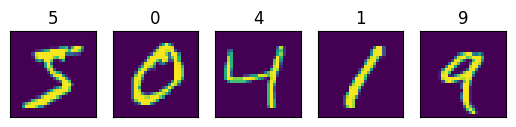

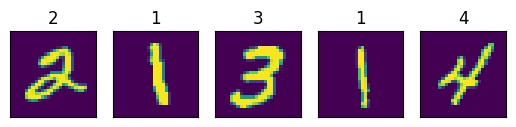

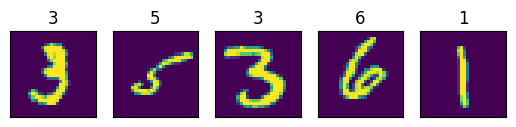

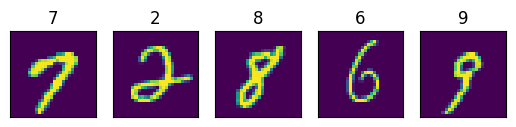

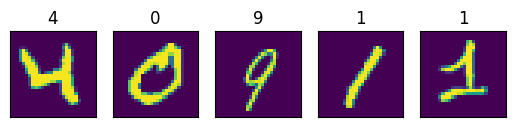

In [16]:
# train dataset
img_row = 5
img_column = 5 # max 9
train_loader = make_loader(batch_size=img_row*img_column, train=True, shuffle=False)
plot_example(train_loader, img_row, img_column)

  0%|          | 0/400 [00:00<?, ?it/s]



0.96
tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5,
        4])
tensor([7, 2, 1, 0, 4, 1, 4, 9, 6, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5,
        4])


  0%|          | 0/400 [00:01<?, ?it/s]


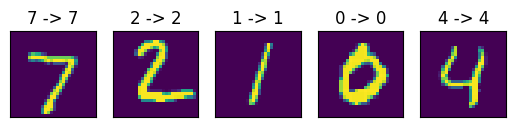

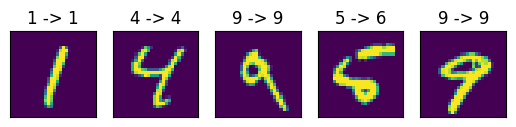

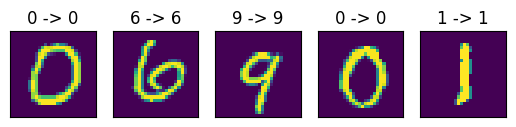

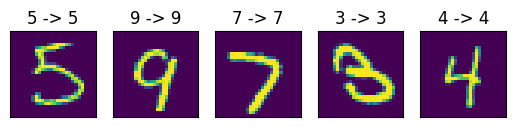

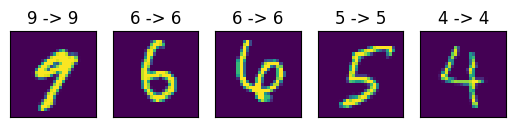

In [17]:
# test dataset (labels -> pred)
test_loader = make_loader(batch_size=img_row*img_column, train=False, shuffle=False)
acc, labels, pred = valid(model, test_loader, first_batch_only=True)
print()
print(acc)
print(labels[0])
print(pred[0])

img_row = 5
img_column = 5 # max 9
plot_example(test_loader, img_row, img_column, pred[0].tolist())

In [18]:
# test dataset (labels -> pred)
# extract error only
err_test_loader = make_loader(batch_size=1, train=False, shuffle=False)

err_image_list = []
err_label_list = []
err_pred_list = []

with torch.no_grad():
    tqdm_loader = tqdm(err_test_loader)
    for images, labels in tqdm_loader:
        logit = model(images)
        pred = torch.argmax(logit, dim=1)
        if labels != pred:
            err_image_list.append(images.numpy())
            err_label_list.append(labels.item())
            err_pred_list.append(pred.item())

print()
print(len(err_image_list))
print(err_label_list)
print(err_pred_list)

100%|██████████| 10000/10000 [00:29<00:00, 336.64it/s]


542
[5, 2, 9, 7, 2, 9, 3, 6, 8, 9, 4, 6, 8, 2, 9, 2, 5, 6, 5, 2, 3, 5, 6, 5, 9, 8, 5, 3, 9, 8, 7, 4, 3, 2, 8, 1, 2, 7, 8, 4, 0, 5, 4, 8, 8, 8, 5, 3, 2, 3, 2, 8, 5, 1, 6, 2, 9, 6, 5, 7, 6, 3, 8, 9, 3, 5, 7, 6, 6, 0, 9, 7, 8, 8, 7, 9, 9, 8, 4, 9, 2, 7, 7, 5, 5, 8, 7, 7, 2, 8, 5, 5, 2, 2, 5, 9, 8, 6, 5, 7, 7, 7, 5, 1, 8, 4, 9, 9, 6, 7, 6, 2, 4, 9, 7, 2, 3, 9, 8, 2, 7, 7, 1, 2, 6, 8, 3, 8, 6, 1, 8, 7, 9, 5, 4, 5, 7, 9, 5, 5, 6, 2, 5, 7, 7, 5, 5, 4, 2, 8, 4, 9, 7, 2, 8, 3, 6, 5, 9, 4, 6, 1, 0, 2, 9, 2, 6, 5, 1, 8, 5, 9, 2, 7, 5, 4, 9, 8, 8, 9, 9, 6, 2, 6, 2, 2, 5, 5, 5, 5, 8, 5, 7, 2, 9, 6, 5, 7, 8, 6, 9, 4, 2, 2, 5, 4, 9, 6, 8, 3, 3, 3, 8, 6, 9, 9, 1, 5, 2, 5, 5, 6, 5, 7, 8, 9, 2, 8, 8, 6, 7, 2, 7, 7, 6, 4, 9, 2, 6, 3, 6, 5, 5, 8, 7, 7, 9, 7, 8, 8, 9, 8, 2, 5, 9, 4, 8, 7, 6, 7, 8, 5, 7, 5, 4, 2, 6, 7, 2, 2, 9, 8, 7, 7, 6, 5, 2, 9, 8, 2, 5, 5, 1, 9, 4, 3, 2, 8, 8, 3, 5, 9, 8, 9, 7, 6, 0, 5, 8, 9, 9, 5, 8, 5, 9, 2, 5, 2, 6, 7, 1, 2, 6, 1, 9, 2, 5, 2, 5, 3, 5, 2, 5, 5, 9, 5, 2, 8, 9, 7, 3, 6

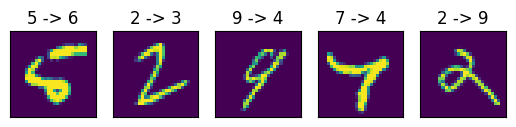

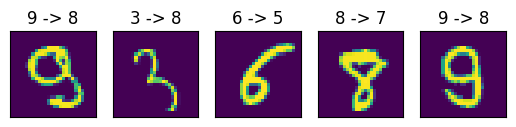

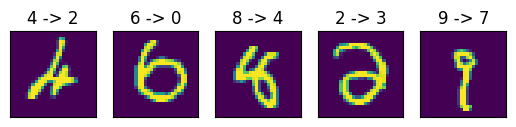

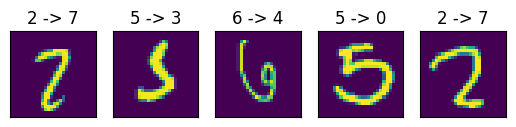

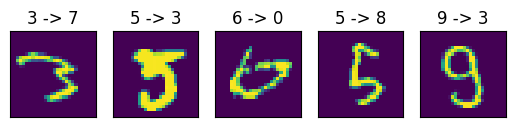

In [19]:
# test dataset (labels -> pred)
# show error only
img_row = 5
img_column = 5 # max 9

for idx in range(img_row * img_column):
    if idx % img_column == 0:
        plt.figure()

    plt.subplot(101 + (img_column)*10 + (idx % img_column))
    plt.imshow(err_image_list[idx].squeeze())
    plt.xticks([])
    plt.yticks([])
    if pred:
        plt.title(str(err_label_list[idx]) + ' -> ' + str(err_pred_list[idx]))
    else:
        plt.title(err_label_list[idx])
